In [141]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [142]:
tf.get_logger().setLevel('ERROR')

In [143]:
import sys
from PIL import Image
sys.modules['Image'] = Image 

In [144]:
import os

num_skipped = 0
for folder_name in ("H", "S", "U", "FG", "OP", "P", "C"):
    folder_path = os.path.join("Signs", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("PNG") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)

Deleted 0 images


In [145]:
image_size = (180, 180)
batch_size = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    "Signs",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "Signs",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 41 files belonging to 7 classes.
Using 33 files for training.
Found 41 files belonging to 7 classes.
Using 8 files for validation.


In [146]:
class_names = train_ds.class_names
print(class_names)

['C', 'FG', 'H', 'OP', 'P', 'S', 'U']


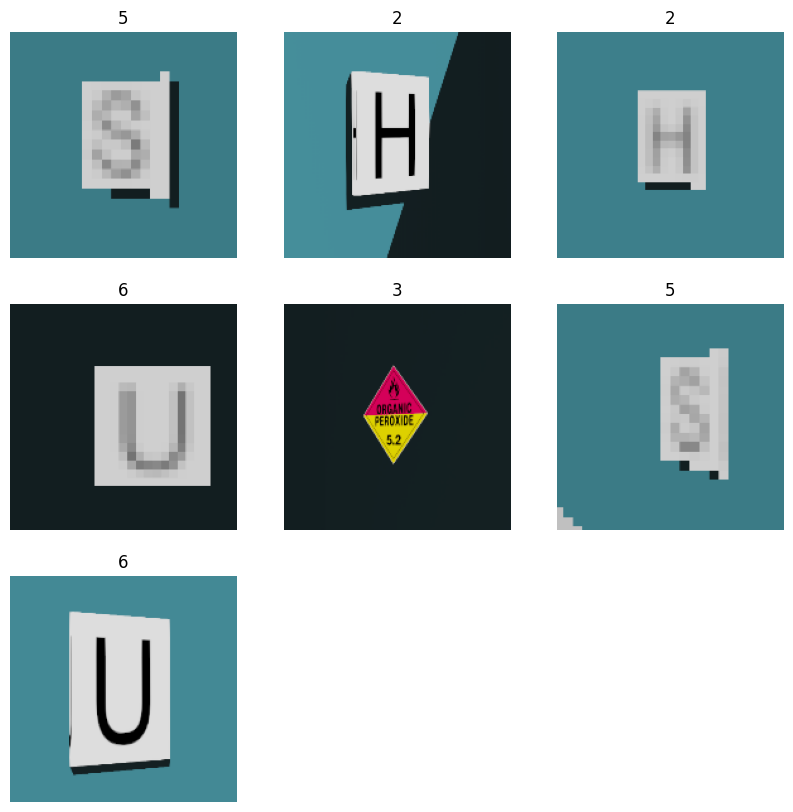

In [147]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(7):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [148]:
data_augmentation = keras.Sequential(
    [
        layers.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode="constant"),
        layers.RandomFlip("horizontal",
                      input_shape=image_size + (3,)),
        layers.RandomZoom(0.1),
    ]
)

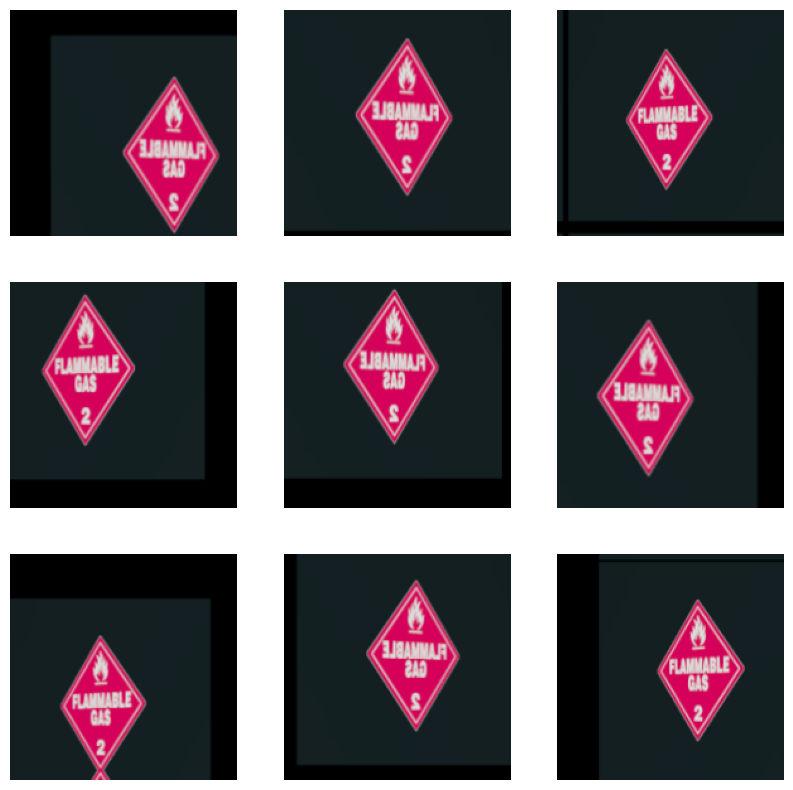

In [149]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [76]:
augmented_train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y))

In [77]:
# Apply `data_augmentation` to the training images.
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label),
    num_parallel_calls=tf.data.AUTOTUNE,
)
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [150]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

normalization_layer = layers.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]

In [151]:
def make_simple_model(input_shape, num_classes):
    model = keras.Sequential(
        [
            keras.Input(shape=input_shape),
            layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
            layers.MaxPooling2D(pool_size=(2, 2)),
            layers.Flatten(),
            layers.Dropout(0.5),
            layers.Dense(num_classes, activation="softmax"),
        ]
    )
    
    return model

In [160]:
def make_tf_simple_model(input_shape, num_classes):
    model = keras.Sequential([
      data_augmentation,
      layers.Rescaling(1./255, input_shape=input_shape),
      layers.Conv2D(16, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(32, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Conv2D(64, 3, padding='same', activation='relu'),
      layers.MaxPooling2D(),
      layers.Dropout(0.2),
      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(num_classes, name="outputs")
    ])
    
    return model

In [161]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

In [174]:
model = make_tf_simple_model(input_shape=image_size + (3,), num_classes=7)

default_epochs = 300

In [175]:
def fit_model(epochs = 100):
    callbacks = [
        keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
    ]
    model.compile(
        optimizer=keras.optimizers.Adam(1e-3),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )

    print(train_ds)

    (x_train, y_train) = train_ds
    (x_test, y_test) = val_ds

    y_train = to_categorical(y_train, 7)
    y_test = to_categorical(y_test, 7)

    history = model.fit(
        x_train,
        y_train,
        epochs=epochs,
        callbacks=callbacks,
        validation_data=(x_test, y_test),
    )
    
    return history

In [176]:
def fit_tf_simple_model(epochs = 100):
    model.compile(optimizer=keras.optimizers.Adam(1e-3),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

    history = model.fit(
      train_ds,
      validation_data=val_ds,
      epochs=epochs
    )
    
    return history

In [177]:
# history = fit_model(default_epochs)
history = fit_tf_simple_model(default_epochs)

Epoch 1/300
2/2 [==============================] - 3s 89ms/step - loss: 1.9507 - accuracy: 0.0606 - val_loss: 3.1663 - val_accuracy: 0.2500
Epoch 2/300
2/2 [==============================] - 0s 34ms/step - loss: 2.0007 - accuracy: 0.1212 - val_loss: 2.9509 - val_accuracy: 0.2500
Epoch 3/300
2/2 [==============================] - 0s 148ms/step - loss: 2.2679 - accuracy: 0.1515 - val_loss: 3.3597 - val_accuracy: 0.2500
Epoch 4/300
2/2 [==============================] - 0s 29ms/step - loss: 2.0603 - accuracy: 0.1515 - val_loss: 2.6861 - val_accuracy: 0.2500
Epoch 5/300
2/2 [==============================] - 0s 147ms/step - loss: 1.5324 - accuracy: 0.3030 - val_loss: 2.8615 - val_accuracy: 0.2500
Epoch 6/300
2/2 [==============================] - 0s 31ms/step - loss: 1.6266 - accuracy: 0.2424 - val_loss: 3.1388 - val_accuracy: 0.1250
Epoch 7/300
2/2 [==============================] - 0s 30ms/step - loss: 1.5487 - accuracy: 0.3333 - val_loss: 3.5891 - val_accuracy: 0.1250
Epoch 8/300
2/2 [=

Epoch 59/300
2/2 [==============================] - 0s 31ms/step - loss: 0.2687 - accuracy: 0.8788 - val_loss: 6.3037 - val_accuracy: 0.6250
Epoch 60/300
2/2 [==============================] - 0s 147ms/step - loss: 0.3667 - accuracy: 0.8788 - val_loss: 7.2980 - val_accuracy: 0.6250
Epoch 61/300
2/2 [==============================] - 0s 30ms/step - loss: 0.3598 - accuracy: 0.8485 - val_loss: 7.3636 - val_accuracy: 0.6250
Epoch 62/300
2/2 [==============================] - 0s 150ms/step - loss: 0.4393 - accuracy: 0.8182 - val_loss: 6.9562 - val_accuracy: 0.6250
Epoch 63/300
2/2 [==============================] - 0s 162ms/step - loss: 0.6905 - accuracy: 0.7576 - val_loss: 6.2061 - val_accuracy: 0.6250
Epoch 64/300
2/2 [==============================] - 0s 31ms/step - loss: 0.6767 - accuracy: 0.7576 - val_loss: 5.4212 - val_accuracy: 0.6250
Epoch 65/300
2/2 [==============================] - 0s 153ms/step - loss: 0.3795 - accuracy: 0.9091 - val_loss: 4.7325 - val_accuracy: 0.6250
Epoch 66/

Epoch 117/300
2/2 [==============================] - 0s 30ms/step - loss: 0.2081 - accuracy: 0.9394 - val_loss: 6.5299 - val_accuracy: 0.6250
Epoch 118/300
2/2 [==============================] - 0s 30ms/step - loss: 0.1644 - accuracy: 0.9394 - val_loss: 6.0906 - val_accuracy: 0.6250
Epoch 119/300
2/2 [==============================] - 0s 147ms/step - loss: 0.1309 - accuracy: 0.9697 - val_loss: 6.2764 - val_accuracy: 0.6250
Epoch 120/300
2/2 [==============================] - 0s 148ms/step - loss: 0.2715 - accuracy: 0.9091 - val_loss: 7.2960 - val_accuracy: 0.6250
Epoch 121/300
2/2 [==============================] - 0s 146ms/step - loss: 0.1718 - accuracy: 0.9091 - val_loss: 8.6112 - val_accuracy: 0.6250
Epoch 122/300
2/2 [==============================] - 0s 155ms/step - loss: 0.2224 - accuracy: 0.8788 - val_loss: 9.4357 - val_accuracy: 0.6250
Epoch 123/300
2/2 [==============================] - 0s 32ms/step - loss: 0.1864 - accuracy: 0.9091 - val_loss: 9.9174 - val_accuracy: 0.6250
Ep

2/2 [==============================] - 0s 154ms/step - loss: 0.1076 - accuracy: 0.9697 - val_loss: 14.0964 - val_accuracy: 0.6250
Epoch 175/300
2/2 [==============================] - 0s 30ms/step - loss: 0.1118 - accuracy: 0.9394 - val_loss: 13.4928 - val_accuracy: 0.6250
Epoch 176/300
2/2 [==============================] - 0s 147ms/step - loss: 0.2096 - accuracy: 0.9091 - val_loss: 12.4411 - val_accuracy: 0.6250
Epoch 177/300
2/2 [==============================] - 0s 148ms/step - loss: 0.0986 - accuracy: 1.0000 - val_loss: 11.0916 - val_accuracy: 0.6250
Epoch 178/300
2/2 [==============================] - 0s 153ms/step - loss: 0.1734 - accuracy: 0.8788 - val_loss: 10.6851 - val_accuracy: 0.6250
Epoch 179/300
2/2 [==============================] - 0s 147ms/step - loss: 0.0929 - accuracy: 0.9394 - val_loss: 11.0629 - val_accuracy: 0.6250
Epoch 180/300
2/2 [==============================] - 0s 33ms/step - loss: 0.1537 - accuracy: 0.9697 - val_loss: 11.7736 - val_accuracy: 0.6250
Epoch 18

2/2 [==============================] - 0s 157ms/step - loss: 0.1074 - accuracy: 0.9394 - val_loss: 15.7736 - val_accuracy: 0.6250
Epoch 232/300
2/2 [==============================] - 0s 30ms/step - loss: 0.0865 - accuracy: 0.9697 - val_loss: 17.2219 - val_accuracy: 0.6250
Epoch 233/300
2/2 [==============================] - 0s 146ms/step - loss: 0.1631 - accuracy: 0.9091 - val_loss: 17.2264 - val_accuracy: 0.6250
Epoch 234/300
2/2 [==============================] - 0s 30ms/step - loss: 0.2782 - accuracy: 0.9091 - val_loss: 14.0120 - val_accuracy: 0.6250
Epoch 235/300
2/2 [==============================] - 0s 31ms/step - loss: 0.0880 - accuracy: 0.9697 - val_loss: 10.2869 - val_accuracy: 0.6250
Epoch 236/300
2/2 [==============================] - 0s 148ms/step - loss: 0.1782 - accuracy: 0.9394 - val_loss: 7.7364 - val_accuracy: 0.7500
Epoch 237/300
2/2 [==============================] - 0s 152ms/step - loss: 0.1364 - accuracy: 0.9394 - val_loss: 6.5140 - val_accuracy: 0.7500
Epoch 238/3

2/2 [==============================] - 0s 28ms/step - loss: 0.0658 - accuracy: 0.9697 - val_loss: 14.8263 - val_accuracy: 0.6250
Epoch 289/300
2/2 [==============================] - 0s 139ms/step - loss: 0.1305 - accuracy: 0.9091 - val_loss: 14.0562 - val_accuracy: 0.6250
Epoch 290/300
2/2 [==============================] - 0s 138ms/step - loss: 0.0325 - accuracy: 1.0000 - val_loss: 12.7223 - val_accuracy: 0.6250
Epoch 291/300
2/2 [==============================] - 0s 29ms/step - loss: 0.0842 - accuracy: 0.9697 - val_loss: 11.5873 - val_accuracy: 0.6250
Epoch 292/300
2/2 [==============================] - 0s 135ms/step - loss: 0.0521 - accuracy: 0.9697 - val_loss: 10.8582 - val_accuracy: 0.6250
Epoch 293/300
2/2 [==============================] - 0s 134ms/step - loss: 0.1569 - accuracy: 0.9394 - val_loss: 10.6348 - val_accuracy: 0.6250
Epoch 294/300
2/2 [==============================] - 0s 30ms/step - loss: 0.1286 - accuracy: 0.9394 - val_loss: 10.9660 - val_accuracy: 0.6250
Epoch 295

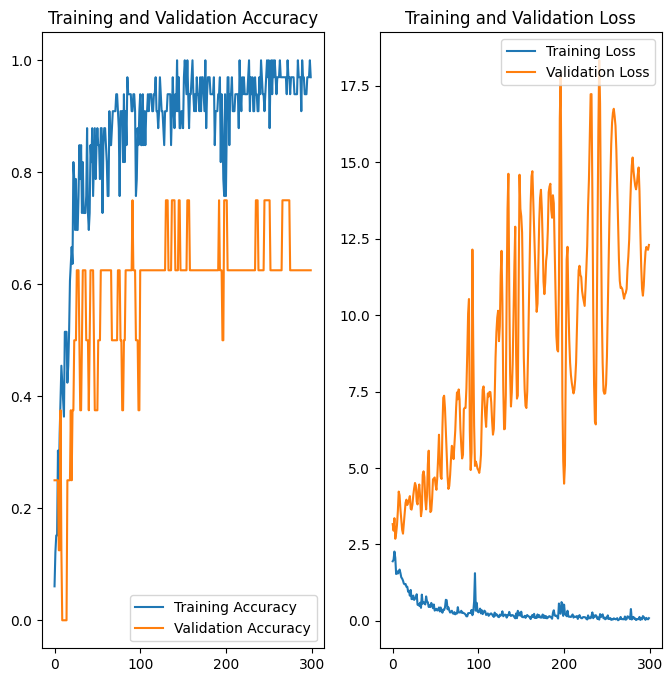

In [178]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(default_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [159]:
img = keras.preprocessing.image.load_img(
    "Signs/H/H0001.png", target_size=image_size
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  # Create batch axis

predictions = model.predict(img_array)
print(predictions)

ImportError: Could not import PIL.Image. The use of `load_img` requires PIL.